In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [12]:
import logging
from itertools import chain

import polars as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from playground.logs import setup_logging

In [3]:
setup_logging()
logger = logging.getLogger(__name__)

# Load data

In [4]:
TRAIN_FILE_PATH = Path.cwd() / "train.csv"
assert TRAIN_FILE_PATH.exists()
assert TRAIN_FILE_PATH.is_file()

In [5]:
train_df = pl.read_csv(TRAIN_FILE_PATH).with_columns([
    pl.lit(0.0).alias("is_old"),
])
train_df.shape

(5407, 11)

In [6]:
TEST_FILE_PATH = Path.cwd() / "test.csv"
assert TEST_FILE_PATH.exists()
assert TEST_FILE_PATH.is_file()

In [7]:
test_df = pl.read_csv(TEST_FILE_PATH).with_columns([
    pl.lit(0.0).alias("is_old"),
])
test_df.shape

(3605, 10)

In [8]:
OLD_TRAIN_FILE_PATH = Path.cwd() / "old.csv"
assert OLD_TRAIN_FILE_PATH.exists()
assert OLD_TRAIN_FILE_PATH.is_file()

In [9]:
old_df = pl.read_csv(OLD_TRAIN_FILE_PATH).with_columns([
    pl.lit(1.0).alias("is_old"),
    pl.lit(-1, dtype=pl.Int64).alias("id"),
])
old_df.shape

(1030, 11)

# Feature engineering

In [10]:
def feature_engineering(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        [
            (
                pl.col("CementComponent")
                + pl.col("BlastFurnaceSlag")
                + pl.col("FlyAshComponent")
                + pl.col("WaterComponent")
                + pl.col("SuperplasticizerComponent")
                + pl.col("CoarseAggregateComponent")
                + pl.col("FineAggregateComponent")
            ).alias("TotalComponent"),
            (pl.col("WaterComponent") / pl.col("CementComponent")).alias("WCR"),
            (
                (pl.col("CoarseAggregateComponent") + pl.col("FineAggregateComponent"))
                / pl.col("CementComponent")
            ).alias("AR"),
            (
                pl.col("WaterComponent")
                / (
                    pl.col("CementComponent")
                    + pl.col("BlastFurnaceSlag")
                    + pl.col("FlyAshComponent")
                )
            ).alias("WCPR"),
            (pl.col("CementComponent") * pl.col("AgeInDays")).alias("CementAge"),
        ]
    )


In [14]:
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)
old_df = feature_engineering(old_df)

# Feature transformation

In [15]:
ID_COLUMN = 'id'
FEATURE_COLUMNS = [
    "CementComponent",
    "BlastFurnaceSlag",
    "FlyAshComponent",
    "WaterComponent",
    "SuperplasticizerComponent",
    "CoarseAggregateComponent",
    "FineAggregateComponent",
    "AgeInDays",
]
FEATURE_ENGINEERING_COLUMNS = [
    "TotalComponent",
    "WCR",
    "AR",
    "WCPR",
    "CementAge",
]
OLD_COLUMN = 'is_old'
TARGET_COLUMN = "Strength"


In [25]:
means = dict(
    zip(
        chain(FEATURE_COLUMNS, FEATURE_ENGINEERING_COLUMNS),
        train_df.select([pl.col(col).mean() for col in chain(FEATURE_COLUMNS, FEATURE_ENGINEERING_COLUMNS)]).row(0),
    )
)
means


{'CementComponent': 299.16818938413167,
 'BlastFurnaceSlag': 58.610578879230644,
 'FlyAshComponent': 31.87279452561494,
 'WaterComponent': 185.0762345108192,
 'SuperplasticizerComponent': 4.10844090993157,
 'CoarseAggregateComponent': 992.0007175883115,
 'FineAggregateComponent': 771.2199741076375,
 'AgeInDays': 51.75161827260958,
 'TotalComponent': 2342.0569299056774,
 'WCR': 0.7113620871120672,
 'AR': 6.799149445747457,
 'WCPR': 0.5093132096756268,
 'CementAge': 16194.54938043278}

In [26]:
stds = dict(
    zip(
        chain(FEATURE_COLUMNS, FEATURE_ENGINEERING_COLUMNS),
        train_df.select([pl.col(col).std() for col in chain(FEATURE_COLUMNS, FEATURE_ENGINEERING_COLUMNS)]).row(0),
    )
)
stds

{'CementComponent': 105.53768168118059,
 'BlastFurnaceSlag': 83.41780074487346,
 'FlyAshComponent': 54.60500297587532,
 'WaterComponent': 18.517583489378303,
 'SuperplasticizerComponent': 5.692296206281762,
 'CoarseAggregateComponent': 77.14801045239005,
 'FineAggregateComponent': 78.72525270217871,
 'AgeInDays': 70.00697526599377,
 'TotalComponent': 82.99079547470946,
 'WCR': 0.2969808984899278,
 'AR': 2.8016614322803455,
 'WCPR': 0.154443627410152,
 'CementAge': 25399.85786075349}

In [27]:
def transform(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        [(pl.col(col) - means[col]) / stds[col] for col in chain(FEATURE_COLUMNS, FEATURE_ENGINEERING_COLUMNS)]
        + [pl.col(OLD_COLUMN)]
    )


In [29]:
train_transformed_df = transform(train_df)
test_transformed_df = transform(test_df)
old_transformed_df = transform(old_df)

In [30]:
train_ids, rest_ids = train_test_split(train_transformed_df[ID_COLUMN], test_size=0.2, random_state=42)

In [31]:
val_ids, eval_ids = train_test_split(rest_ids, test_size=0.5, random_state=42)

In [32]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_ids), len(val_ids), len(eval_ids))

[2023-03-11 11:17:43,470][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [33]:
train_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(train_ids))
val_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(val_ids))
eval_split_df = train_transformed_df.filter(pl.col(ID_COLUMN).is_in(eval_ids))

In [34]:
logger.debug("Train samples %s, validation samples %s, evaluation samples %s", len(train_split_df), len(val_split_df), len(eval_split_df))

[2023-03-11 11:17:49,550][   DEBUG][__main__] Train samples 4325, validation samples 541, evaluation samples 541


In [35]:
train_and_old_split_df = pl.concat([train_split_df, old_transformed_df.select(train_split_df.columns)])
train_and_old_split_df.shape

(5355, 16)

In [36]:
def df_to_dataset(df: pl.DataFrame) -> tf.data.Dataset:
    return tf.data.Dataset.from_tensor_slices({
        col: df[col].to_numpy()
        for col in df.columns
    })

In [37]:
def pop_target(tensors: dict[str, tf.Tensor]) -> tuple[dict[str, tf.Tensor], tf.Tensor]:
    target = tensors.pop(TARGET_COLUMN)
    return tensors, target

In [38]:
batch_size = 32
train_ds = df_to_dataset(train_and_old_split_df).shuffle(len(train_and_old_split_df), reshuffle_each_iteration=True).batch(batch_size).map(pop_target)
val_ds = df_to_dataset(val_split_df).batch(batch_size).map(pop_target)
eval_ds = df_to_dataset(eval_split_df).batch(batch_size).map(pop_target)

2023-03-11 11:18:01.203374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-11 11:18:01.203709: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 11:18:01.203747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zenbook): /proc/driver/nvidia/version does not exist
2023-03-11 11:18:01.206038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
for inputs, target in train_ds.take(1):
    logger.debug("Inputs: %s", inputs)
    logger.debug("Target: %s", target)

[2023-03-11 11:18:03,708][   DEBUG][__main__] Inputs: {'id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([5153, 3587,  572, 4048, 4755, 3625, 3781,   -1, 2147, 1314, 2561,
         78, 1988, 2535,   52, 2162,   -1,  276,  943,   -1,   -1, 3898,
         41, 2866, 2828, 3694, 5311, 5110,  703,  503, 2964, 2980])>, 'CementComponent': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.82120611, -0.5843239 ,  2.19951592,  0.7185283 ,  0.60103472,
       -1.5460657 , -0.80888824, -1.50911207, -0.80888824, -1.03440011,
       -0.09634653,  2.28195093,  2.28195093,  1.90293938,  0.31582853,
        0.88908349, -0.95291263,  0.10263453, -0.702765  , -0.44693221,
       -1.25422681,  0.30161559,  0.47217079,  1.66605716, -0.63833304,
        1.21598095, -1.19548002,  0.05810068,  1.81766178, -1.80853119,
        0.88908349, -0.44693221])>, 'BlastFurnaceSlag': <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([-0.70261477,  2.14449937, -0.70261477, -0.70261477,  1.56308869,
     

In [40]:
id_input = tf.keras.Input(shape=(), name=ID_COLUMN, dtype=tf.int64)
feature_inputs = {
    col: tf.keras.Input(shape=(), name=col, dtype=tf.float32)
    for col in FEATURE_COLUMNS
}
feature_engineering_inputs = {
    col: tf.keras.Input(shape=(), name=col, dtype=tf.float32)
    for col in FEATURE_ENGINEERING_COLUMNS
}
old_input = tf.keras.Input(shape=(), name=OLD_COLUMN, dtype=tf.float32)

In [43]:
concatenated_features = tf.stack([*feature_inputs.values(), *feature_engineering_inputs.values(), old_input], axis=1)
seq = tf.keras.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1),
])
output = seq(concatenated_features)

In [44]:
model = tf.keras.Model(inputs={**feature_inputs, **feature_engineering_inputs, OLD_COLUMN: old_input}, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()],
)

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=10, restore_best_weights=True, verbose=1
        ),
    ],
)


Epoch 1/100


/home/kurazu/workspace/kaggle-playground-s03-e02/.venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


168/168 [==============================] - 3s 5ms/step - loss: 1329.4598 - mean_absolute_error: 33.1509 - root_mean_squared_error: 36.4618 - val_loss: 1208.7167 - val_mean_absolute_error: 31.4945 - val_root_mean_squared_error: 34.7666
Epoch 2/100
168/168 [==============================] - 1s 4ms/step - loss: 834.0414 - mean_absolute_error: 25.4905 - root_mean_squared_error: 28.8798 - val_loss: 655.4351 - val_mean_absolute_error: 22.1879 - val_root_mean_squared_error: 25.6015
Epoch 3/100
168/168 [==============================] - 1s 4ms/step - loss: 397.8356 - mean_absolute_error: 16.0743 - root_mean_squared_error: 19.9458 - val_loss: 229.9065 - val_mean_absolute_error: 11.5283 - val_root_mean_squared_error: 15.1627
Epoch 4/100
168/168 [==============================] - 1s 4ms/step - loss: 191.0296 - mean_absolute_error: 10.3287 - root_mean_squared_error: 13.8213 - val_loss: 150.7312 - val_mean_absolute_error: 9.4291 - val_root_mean_squared_error: 12.2773
Epoch 5/100
168/168 [==========

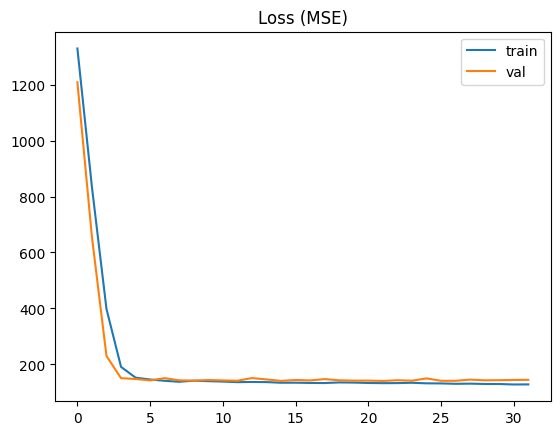

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss (MSE)')
plt.legend()

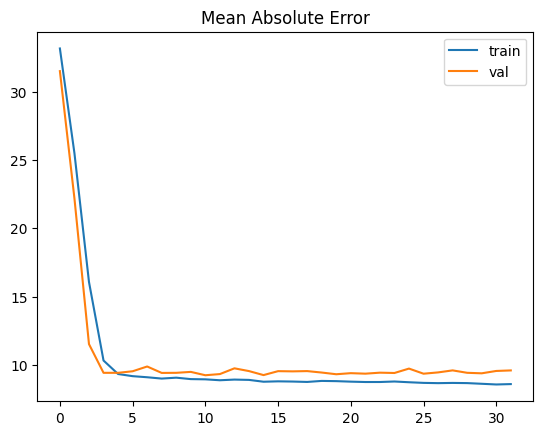

In [47]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='val')
plt.title('Mean Absolute Error')
plt.legend()

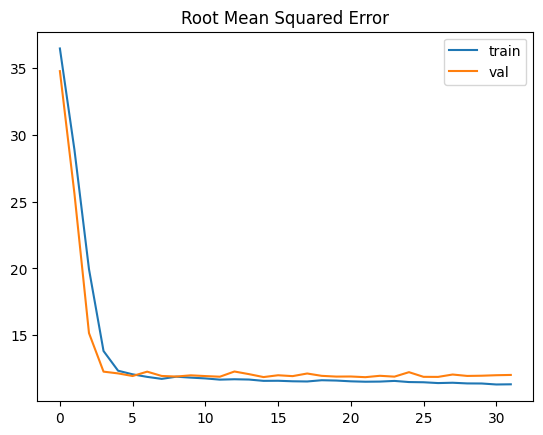

In [48]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='val')
plt.title('Root Mean Squared Error')
plt.legend()

In [49]:
eval_mse, eval_mae, eval_rmse = model.evaluate(eval_ds)
logger.info("Evaluation MSE: %s, MAE: %s, RMSE: %s", eval_mse, eval_mae, eval_rmse)

17/17 [==============================] - 0s 3ms/step - loss: 150.3710 - mean_absolute_error: 9.5584 - root_mean_squared_error: 12.2626


[2023-03-11 11:19:55,838][    INFO][__main__] Evaluation MSE: 150.37098693847656, MAE: 9.558380126953125, RMSE: 12.262584686279297


In [51]:
wrapper_model = tf.keras.Model(
    inputs={
        ID_COLUMN: id_input,
        OLD_COLUMN: old_input,
        **feature_inputs,
        **feature_engineering_inputs,
    },
    outputs={
        ID_COLUMN: id_input,
        TARGET_COLUMN: tf.squeeze(
            model(
                {**feature_inputs, **feature_engineering_inputs, OLD_COLUMN: old_input},
                training=False,
            ),
            axis=1,
        ),
    },
)


In [52]:
test_ds = df_to_dataset(test_transformed_df).batch(batch_size)

In [53]:
predictions = wrapper_model.predict(test_ds)

113/113 [==============================] - 1s 3ms/step


In [54]:
{k: v.shape for k, v in predictions.items()}

{'id': (3605,), 'Strength': (3605,)}

In [55]:
pl.DataFrame(predictions).write_csv(Path.cwd() / 'submission.csv')